# Introduction

We are using the WESAD dataset (Wearable Stress and Affect Detection) 
to train our classification algorithms to detect stress. This multimodal dataset contains physiological and motion sensor data from 15 subjects during a lab study, where they are exposed to different stimuli (stress, amusement, meditation and baseline). The data includes the subjects’ blood volume pulse, electro-cardiogram, electrodermal activity, electromyogram, body temperature, and three-axis acceleration. Although the dataset contains measurements from both a wrist- anda chest-worn device, we only use the data from the wrist-worn device here,
since we are emulating measurements from a smartwatch.

We detect stress using:

* EDA
* EMG/BVP
* Temperature
* Accelerometer

The original article for the dataset can be found here: https://www.eti.uni-siegen.de/ubicomp/papers/ubi_icmi2018.pdf-

In [7]:
!pip install matplotlib seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [8]:
# Project wide dependencies

import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

In [9]:
%matplotlib inline
plt.rcParams["figure.figsize"]=20,12

In [10]:
#! pip install ipympl

# Getting the data

We get the data from the UCI Machine Learning Repository, see here: https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29

Uncomment the next to cells to get the data. Warning: Large download ahead :)

In [11]:
#!wget https://uni-siegen.sciebo.de/s/pYjSgfOVs6Ntahr/download


In [12]:
#!unzip -o WESAD.zip

In [13]:
# Create a test set of two subjects and set aside
# 2/15 = 13%
# (Only view at the very end of the project!)

subject_numbers = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
#test_subject1 = random.choice(subject_numbers)

#print(test_subject1)
#print(test_subject2)

# Got 3 and 10
subject_numbers.remove(3)
subject_numbers.remove(10)
print(subject_numbers)

[2, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17]


In [14]:
testing_subjects = ['S3', 'S10']
training_subjects = ['S' + str(num) for num in subject_numbers]
print('Testing subjects: ' + str(testing_subjects))
print('Training subjects: ' + str(training_subjects))

Testing subjects: ['S3', 'S10']
Training subjects: ['S2', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17']


# Exploring the data

In the following section, we explore the data by:

* Creating a downsampled copy of the data for exploration
    * Downsampled full dataset
    * Full resolution short dataset
* Checking for missing values, means, stds etc.
* Reformating the target variable, remove segments if neccesary
* Visualizing the data
* Studying correlations
* Suggesting manual method of classification
* Suggesting naive classifiers

In [15]:
# We know the sampling frequencies of the different modalities 
# from the original article (in Hz)

frequency_dict = {
    'label': 700,
    'chest': {
        'ACC': 700,
        'ECG': 700,
        'EMG': 700,
        'EDA': 700,
        'Temp': 700,
        'Resp': 700
    },
    'wrist': {
        'ACC': 32,
        'BVP': 64,
        'EDA': 4,
        'TEMP': 4
    }
}

# Downsampled full dataset

First, we look at the full experiment time duration, but downsampled to decrease data size

In [16]:
# Select random subject to explore

expl_subj = random.choice(training_subjects)
print('Looking at subject ' + expl_subj)

expl_data_dict = {}
with open('WESAD/' + expl_subj + '/' + expl_subj + '.pkl', 'rb') as f:
    expl_data_dict = pickle.load(f, encoding='bytes')
    
relabeling_dict_categories = {
    0: 0, # Not defined
    1: 1, # Baseline
    2: 2, # Stress
    3: 3, #Amusement
    4: 4, # Meditation
    5: 0, # Not defined
    6: 0, # Not defined
    7: 0 # Not defined
}

relabeling_dict_stress = {
    0: 0, # Not defined
    1: 0, # Baseline
    2: 1, # Stress
    3: 0, #Amusement
    4: 0, # Meditation
    5: 0, # Not defined
    6: 0, # Not defined
    7: 0 # Not defined
}

# Resampling the data to 1 Hz
expl_data_dict_resampled = {}
expl_data_dict_resampled['label'] = expl_data_dict[b'label'][0::frequency_dict['label']]
expl_data_dict_resampled['stress_label'] = []
expl_data_dict_resampled['cat_label'] = []
for label in expl_data_dict_resampled['label']:
    expl_data_dict_resampled['stress_label'].append(relabeling_dict_stress[label])
for label in expl_data_dict_resampled['label']:
    expl_data_dict_resampled['cat_label'].append(relabeling_dict_categories[label])
expl_data_dict_resampled['time'] = range(len(expl_data_dict_resampled['label']))
expl_data_dict_resampled['subject'] = [expl_subj]*len(expl_data_dict_resampled['label'])
for m in frequency_dict['chest']:
    if m == 'ACC':
        for direction in range(3):
            expl_data_dict_resampled.update(
                {
                    'chest-ACC-' + str(direction): expl_data_dict[b'signal'][bytes('chest', 'utf-8')][bytes(m, 'utf-8')][:,direction][0::frequency_dict['chest'][m]]
                }
            )
    else:
        expl_data_dict_resampled.update(
            {
                'chest-' + m: expl_data_dict[b'signal'][bytes('chest', 'utf-8')][bytes(m, 'utf-8')][0::frequency_dict['chest'][m]]
            }
        )
for m in frequency_dict['wrist']:
    if m == 'ACC':
        for direction in range(3):
            expl_data_dict_resampled.update(
                {
                    'wrist-ACC-' + str(direction): expl_data_dict[b'signal'][bytes('wrist', 'utf-8')][bytes(m, 'utf-8')][:,direction][0::frequency_dict['wrist'][m]]
                }
            )
    else:
        expl_data_dict_resampled.update(
            {
                'wrist-' + m: expl_data_dict[b'signal'][bytes('wrist', 'utf-8')][bytes(m, 'utf-8')][0::frequency_dict['wrist'][m]]
            }
        )

Looking at subject S17


In [17]:
# Flattening
for m in expl_data_dict_resampled.keys():
    expl_data_dict_resampled[m] = np.array(expl_data_dict_resampled[m]).flatten()

# Verifying all resampled lists have the same length and correct names
for m in expl_data_dict_resampled.keys():
    print('Length of ' + m + ': ' + str(np.shape(expl_data_dict_resampled[m])))

Length of label: (5920,)
Length of stress_label: (5920,)
Length of cat_label: (5920,)
Length of time: (5920,)
Length of subject: (5920,)
Length of chest-ACC-0: (5920,)
Length of chest-ACC-1: (5920,)
Length of chest-ACC-2: (5920,)
Length of chest-ECG: (5920,)
Length of chest-EMG: (5920,)
Length of chest-EDA: (5920,)
Length of chest-Temp: (5920,)
Length of chest-Resp: (5920,)
Length of wrist-ACC-0: (5920,)
Length of wrist-ACC-1: (5920,)
Length of wrist-ACC-2: (5920,)
Length of wrist-BVP: (5920,)
Length of wrist-EDA: (5920,)
Length of wrist-TEMP: (5920,)


In [18]:
expl_df = pd.DataFrame(expl_data_dict_resampled)
expl_df['label_str'] = expl_df['stress_label'].astype(str)
expl_df['category_str'] = expl_df['cat_label'].astype(str)

In [19]:
expl_df

,label,stress_label,cat_label,time,subject,chest-ACC-0,chest-ACC-1,chest-ACC-2,chest-ECG,chest-EMG,...,chest-Temp,chest-Resp,wrist-ACC-0,wrist-ACC-1,wrist-ACC-2,wrist-BVP,wrist-EDA,wrist-TEMP,label_str,category_str
0,0,0,0,0,S17,0.7002,-0.1982,-1.0702,1.431793,0.007095,...,32.415283,3.221130,-36.0,-38.0,-128.0,-0.49,2.015176,33.39,0,0
1,0,0,0,1,S17,0.9074,-0.0730,-0.1530,-0.042252,0.010483,...,32.412262,-2.928162,-50.0,-43.0,6.0,-55.02,1.979353,33.37,0,0
2,0,0,0,2,S17,0.9024,-0.0640,-0.1690,0.213089,0.018082,...,32.427155,3.015137,-50.0,-41.0,6.0,19.91,1.968359,33.34,0,0
3,0,0,0,3,S17,0.9018,-0.0610,-0.1672,-0.014969,-0.020187,...,32.428680,1.673889,-50.0,-41.0,6.0,1.16,1.986270,33.34,0,0
4,0,0,0,4,S17,0.8218,-0.2786,-0.1718,-0.124924,0.056946,...,32.403351,-4.132080,58.0,46.0,80.0,-4.26,2.008020,33.34,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,0,0,0,5915,S17,0.9050,-0.0318,-0.1766,-0.011673,-0.002701,...,33.876465,7.298279,-52.0,59.0,17.0,-33.75,0.854978,31.85,0,0
5916,0,0,0,5916,S17,0.9086,-0.0232,-0.1650,-0.068344,-0.019958,...,33.899231,-1.786804,-48.0,-35.0,3.0,-83.26,0.833228,31.83,0,0
5917,0,0,0,5917,S17,0.9066,-0.0560,-0.1626,-0.011993,-0.001419,...,33.859741,-5.253601,-54.0,-37.0,-5.0,-110.22,0.817875,31.83,0,0
5918,0,0,0,5918,S17,0.9106,-0.0478,-0.1626,-0.053513,-0.003616,...,33.862762,-5.616760,-50.0,-37.0,-3.0,10.21,0.794846,31.81,0,0


In [20]:
expl_df.describe()

,label,stress_label,cat_label,time,chest-ACC-0,chest-ACC-1,chest-ACC-2,chest-ECG,chest-EMG,chest-EDA,chest-Temp,chest-Resp,wrist-ACC-0,wrist-ACC-1,wrist-ACC-2,wrist-BVP,wrist-EDA,wrist-TEMP
count,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000
mean,1.302365,0.122128,1.126182,2959.500000,0.633101,-0.016038,-0.580841,-0.003639,-0.003633,6.491431,33.773972,0.047627,-45.363345,-5.430912,9.630912,-0.378397,1.080486,32.706584
std,1.615245,0.327462,1.400453,1709.101128,0.233127,0.060008,0.315613,0.278245,0.017743,0.810466,0.423208,4.804488,13.928761,27.723777,32.881898,47.889163,0.248334,0.448778
min,0.000000,0.000000,0.000000,0.000000,0.252600,-0.449400,-1.070200,-0.897034,-0.136185,5.276871,32.156281,-27.403259,-120.000000,-64.000000,-128.000000,-492.940000,0.759023,31.810000
25%,0.000000,0.000000,0.000000,1479.750000,0.386200,-0.059800,-0.885400,-0.111980,-0.011227,5.739975,33.529327,-2.381897,-55.250000,-28.000000,-8.000000,-14.210000,0.934301,32.330000
50%,1.000000,0.000000,1.000000,2959.500000,0.646200,-0.002200,-0.681900,-0.040855,-0.003639,6.291199,33.677673,-0.272369,-46.000000,-3.000000,7.000000,0.740000,1.016183,32.650000
75%,2.000000,0.000000,2.000000,4439.250000,0.877200,0.026600,-0.275800,0.016216,0.003708,7.224655,34.106201,2.662659,-38.000000,5.000000,40.000000,12.925000,1.091767,33.050000
max,7.000000,1.000000,4.000000,5919.000000,1.546600,0.186600,0.449800,1.499222,0.235336,8.154678,34.607880,28.373718,62.000000,88.000000,92.000000,415.270000,2.507747,33.530000


In [21]:
expl_df.dtypes

label             int32
stress_label      int64
cat_label         int64
time              int64
subject          object
chest-ACC-0     float64
chest-ACC-1     float64
chest-ACC-2     float64
chest-ECG       float64
chest-EMG       float64
chest-EDA       float64
chest-Temp      float32
chest-Resp      float64
wrist-ACC-0     float64
wrist-ACC-1     float64
wrist-ACC-2     float64
wrist-BVP       float64
wrist-EDA       float64
wrist-TEMP      float64
label_str        object
category_str     object
dtype: object

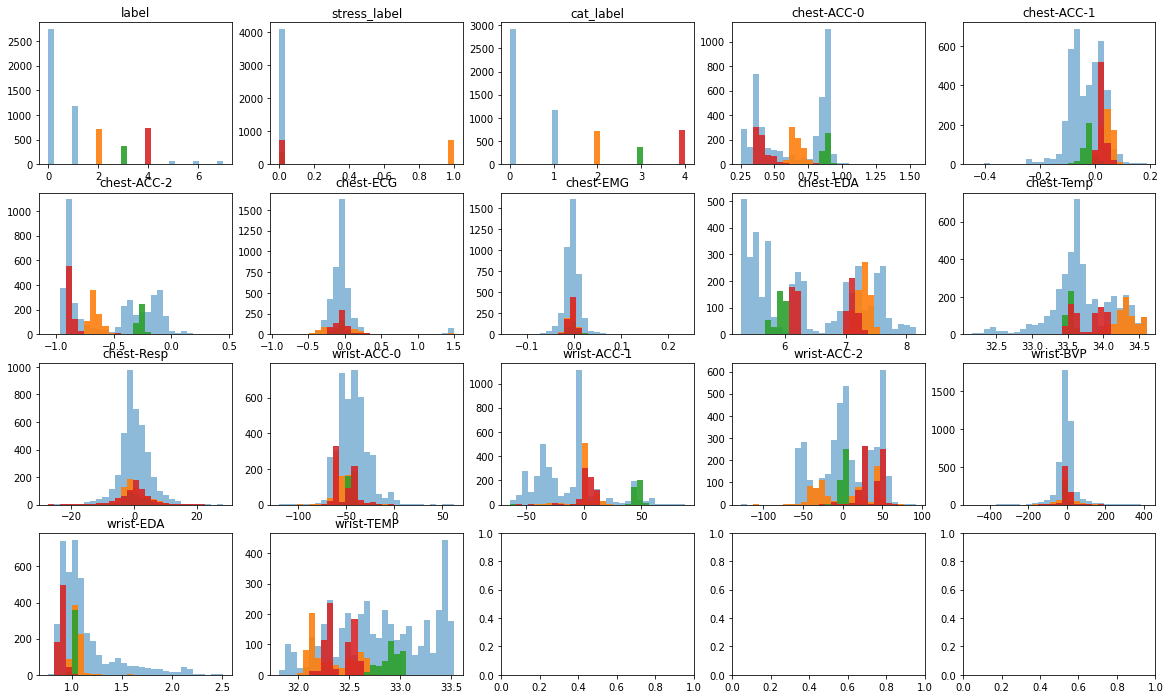

In [22]:
fig, axs = plt.subplots(4, 5)
ax = axs.reshape(-1)
i = 0
for col in expl_df.columns.drop('subject').drop('time').drop('label_str').drop('category_str'):
    colmin = expl_df[col].min()
    colmax = expl_df[col].max()
    bins = np.linspace(colmin, colmax, 30)
    ax[i].hist(expl_df.query('cat_label != 2 & cat_label != 3 & cat_label != 4')[col], alpha=0.5, bins=bins)
    ax[i].hist(expl_df.query('cat_label == 2')[col], alpha=0.9, bins=bins)
    ax[i].hist(expl_df.query('cat_label == 3')[col], alpha=0.9, bins=bins)
    ax[i].hist(expl_df.query('cat_label == 4')[col], alpha=0.9, bins=bins)
    #ax[i].set_yscale('log')
    ax[i].set_title(col)
    i = i+1

In [23]:
expl_df.corr()

,label,stress_label,cat_label,time,chest-ACC-0,chest-ACC-1,chest-ACC-2,chest-ECG,chest-EMG,chest-EDA,chest-Temp,chest-Resp,wrist-ACC-0,wrist-ACC-1,wrist-ACC-2,wrist-BVP,wrist-EDA,wrist-TEMP
label,1.000000,0.161109,0.779294,0.054491,-0.166586,0.248051,-0.207703,0.009663,-0.017417,-0.023690,0.002599,-0.000695,-0.153413,0.106658,0.042411,-0.002434,-0.172722,-0.081594
stress_label,0.161109,1.000000,0.232746,0.199593,0.054364,0.347101,-0.094239,0.010088,-0.012959,0.364522,0.461180,0.001656,-0.229960,0.103331,-0.079113,0.014903,-0.049600,-0.324416
cat_label,0.779294,0.232746,1.000000,0.076418,-0.325220,0.239120,-0.367035,0.012278,-0.011569,-0.026235,0.016836,-0.000051,-0.158779,0.266733,0.080750,-0.004648,-0.134628,-0.116348
time,0.054491,0.199593,0.076418,1.000000,0.150835,0.384260,0.119316,0.006264,-0.023045,0.923701,0.782356,0.001636,-0.110186,0.119986,0.355271,0.015450,-0.657034,-0.829305
chest-ACC-0,-0.166586,0.054364,-0.325220,0.150835,1.000000,0.011923,0.952802,-0.020452,0.022070,0.252316,0.077291,-0.006306,-0.001482,0.502538,0.281315,0.012364,-0.144990,-0.276269
chest-ACC-1,0.248051,0.347101,0.239120,0.384260,0.011923,1.000000,-0.107920,0.022741,0.001235,0.351492,0.358339,-0.013180,-0.254325,0.151876,0.251464,0.011587,-0.388694,-0.429382
chest-ACC-2,-0.207703,-0.094239,-0.367035,0.119316,0.952802,-0.107920,1.000000,-0.029047,0.019181,0.190321,-0.007820,-0.005847,0.036984,0.469272,0.306690,0.005708,-0.103430,-0.237963
chest-ECG,0.009663,0.010088,0.012278,0.006264,-0.020452,0.022741,-0.029047,1.000000,-0.098684,0.002860,0.014158,0.013329,-0.002302,-0.019175,-0.012443,0.009357,-0.013197,-0.004448
chest-EMG,-0.017417,-0.012959,-0.011569,-0.023045,0.022070,0.001235,0.019181,-0.098684,1.000000,-0.024769,-0.030602,0.000176,-0.011357,0.012568,0.004645,-0.013855,0.015343,0.004875
chest-EDA,-0.023690,0.364522,-0.026235,0.923701,0.252316,0.351492,0.190321,0.002860,-0.024769,1.000000,0.835091,0.001814,-0.149404,0.110207,0.264419,0.022160,-0.538835,-0.759348


<AxesSubplot:>

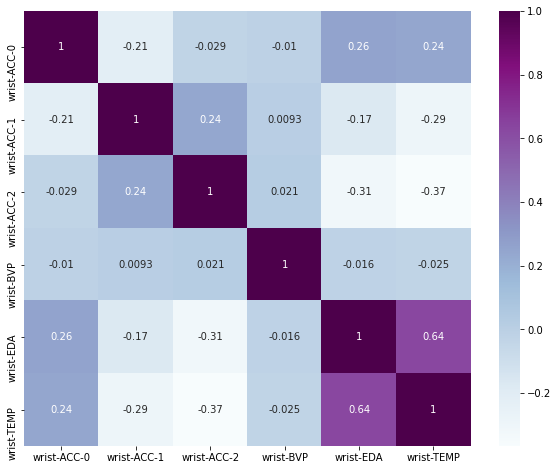

In [24]:
# Correlation with heatmap of wrist features

wrist_df = expl_df[[
    'wrist-ACC-0',
    'wrist-ACC-1',
    'wrist-ACC-2',
    'wrist-BVP',
    'wrist-EDA',
    'wrist-TEMP'
]]
plt.figure(figsize=(10,8))
sns.heatmap(wrist_df.corr(), annot=True, cmap=plt.cm.BuPu)

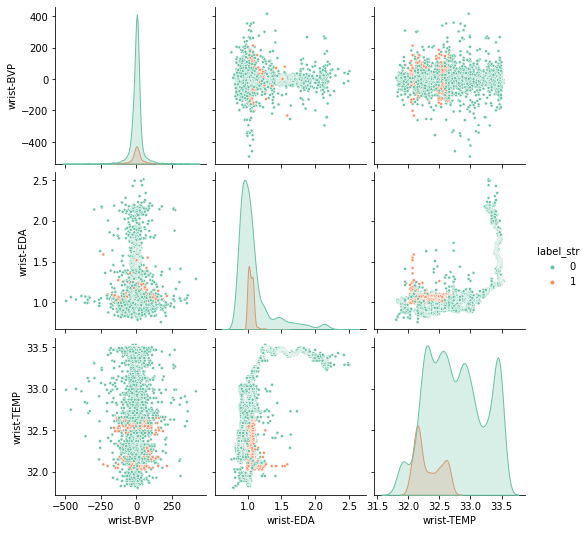

In [25]:
# Corollogram/pairplot

sns.pairplot(expl_df[['label_str','wrist-BVP', 'wrist-EDA', 'wrist-TEMP']], kind="scatter", hue="label_str", markers=[".", "."], palette="Set2")
plt.show()

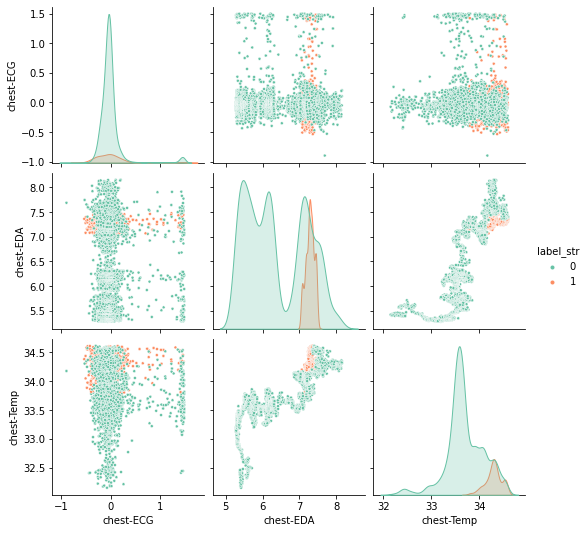

In [26]:
# Corollogram/pairplot

sns.pairplot(expl_df[['label_str','chest-ECG', 'chest-EDA', 'chest-Temp']], kind="scatter", hue="label_str", markers=[".", "."], palette="Set2")
plt.show()

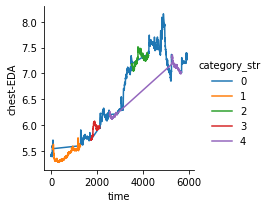

In [27]:
fg = sns.FacetGrid(data=expl_df, hue='category_str', hue_order=['0', '1', '2', '3', '4'])
fg.map(plt.plot, 'time','chest-EDA').add_legend()

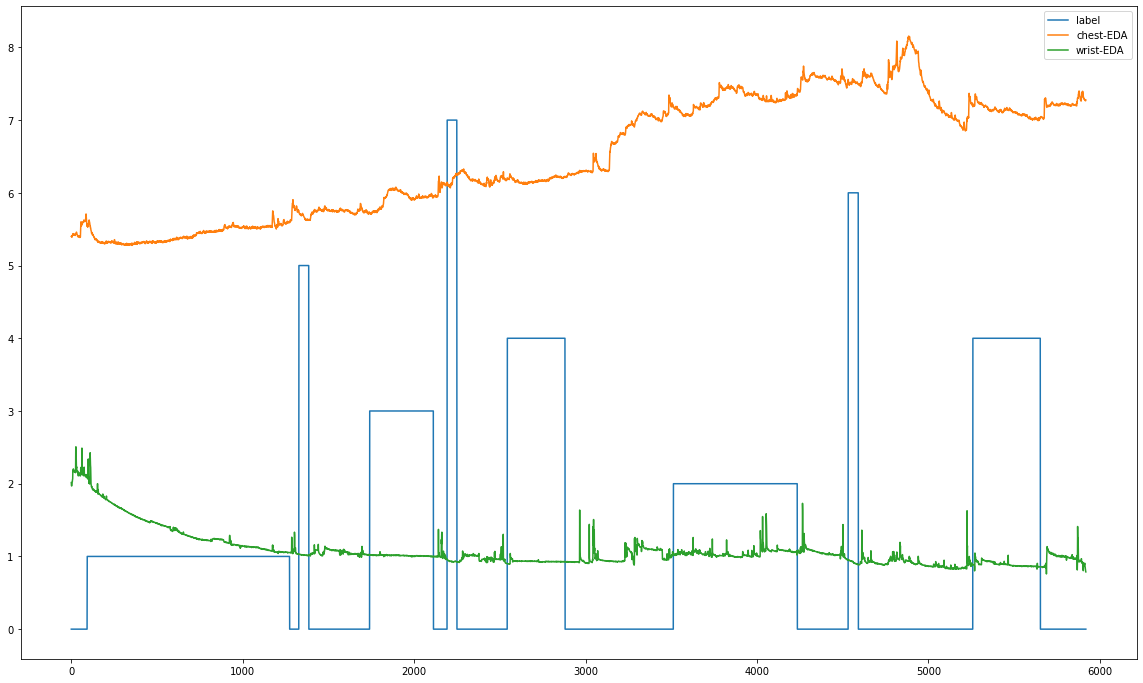

In [28]:
plt.plot(expl_df['label'])
plt.plot(expl_df['chest-EDA'])
plt.plot(expl_df['wrist-EDA'])
plt.legend(['label', 'chest-EDA', 'wrist-EDA'])

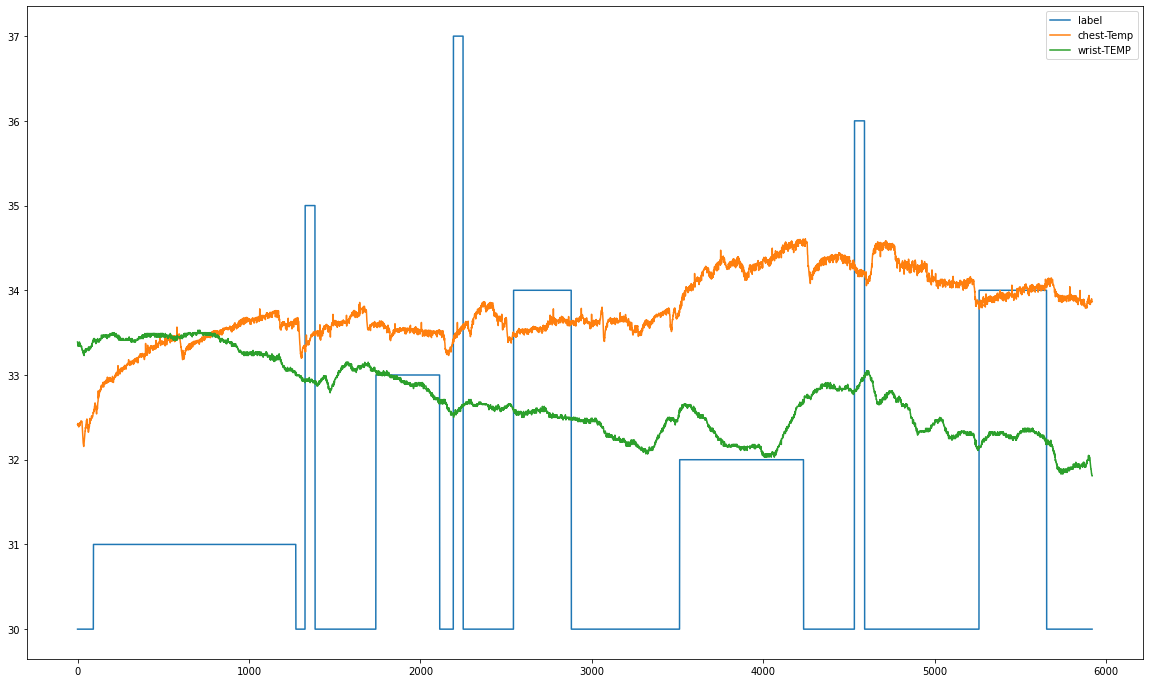

In [29]:
plt.plot(expl_df['label']+30)
plt.plot(expl_df['chest-Temp'])
plt.plot(expl_df['wrist-TEMP'])
plt.legend(['label', 'chest-Temp', 'wrist-TEMP'])

# Full resolution

Now we explore parts of the dataset in full resolution, but short time durations

In [30]:
# Pick a second of the experiment at random
# We know the labels are sampled every 700 Hz
duration = int(len(expl_data_dict[b'label'])/frequency_dict['label']) # in seconds
print('Experiment duration: ' + str(duration) + ' seconds (' + str(datetime.timedelta(seconds=duration)) +')')
selected_second = random.choice(range(duration))
print('Selected second: ' + str(selected_second))
sample_duration = 60 # seconds

expl_data_dict_short = {}
expl_data_dict_short['label'] = expl_data_dict[b'label'][selected_second*frequency_dict['label']] # Selecting the label at the start
expl_data_dict_short['subject'] = expl_subj
for m in frequency_dict['chest']:
    if m == 'ACC':
        for direction in range(3):
            expl_data_dict_short.update(
                {
                    'chest-ACC-' + str(direction): expl_data_dict[b'signal'][b'chest'][bytes(m, 'utf-8')][:,direction][selected_second*frequency_dict['chest'][m]:selected_second*frequency_dict['chest'][m]+sample_duration*frequency_dict['chest'][m]]
                }
            )
    else:
        expl_data_dict_short.update(
            {
                'chest-' + m: expl_data_dict[b'signal'][b'chest'][bytes(m, 'utf-8')][selected_second*frequency_dict['chest'][m]:selected_second*frequency_dict['chest'][m]+sample_duration*frequency_dict['chest'][m]]
            }
        )
for m in frequency_dict['wrist']:
    if m == 'ACC':
        for direction in range(3):
            expl_data_dict_short.update(
                {
                    'wrist-ACC-' + str(direction): expl_data_dict[b'signal'][b'wrist'][bytes(m, 'utf-8')][:,direction][selected_second*frequency_dict['wrist'][m]:selected_second*frequency_dict['wrist'][m]+sample_duration*frequency_dict['wrist'][m]]
                }
            )
    else:
        expl_data_dict_short.update(
            {
                'wrist-' + m: expl_data_dict[b'signal'][b'wrist'][bytes(m, 'utf-8')][selected_second*frequency_dict['wrist'][m]:selected_second*frequency_dict['wrist'][m]+sample_duration*frequency_dict['wrist'][m]]
            }
        )

Experiment duration: 5920 seconds (1:38:40)
Selected second: 3087


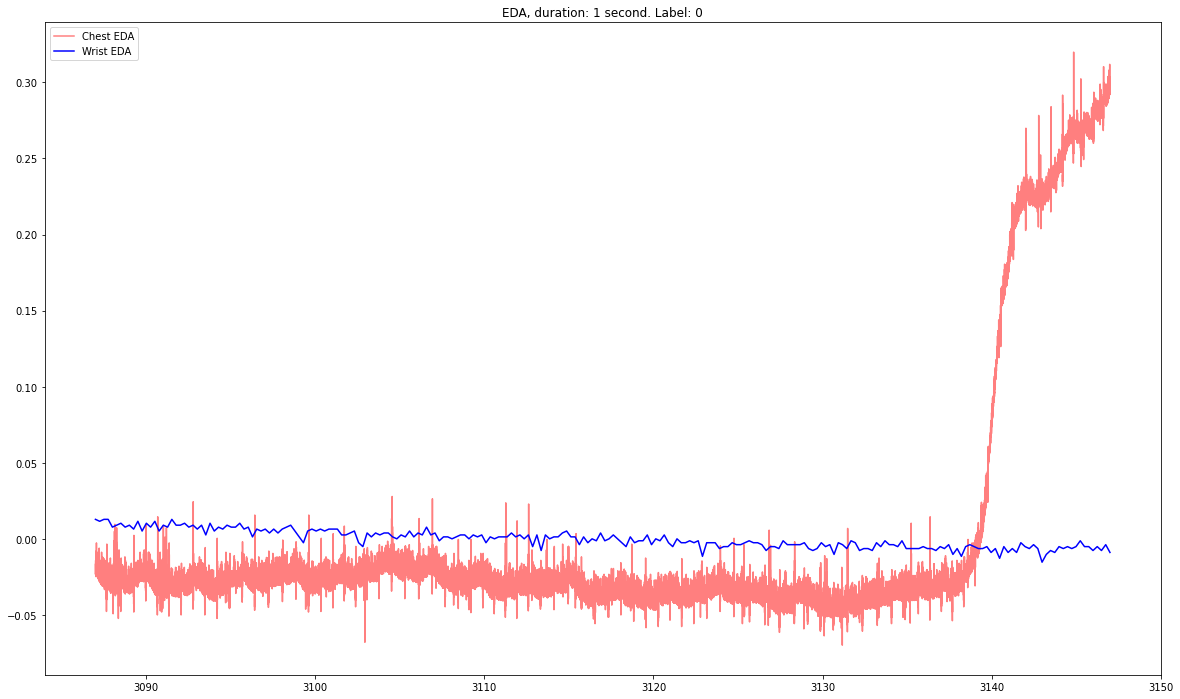

In [31]:

plt.plot(np.linspace(selected_second, selected_second + sample_duration, num=sample_duration*frequency_dict['chest']['EDA']), expl_data_dict_short['chest-EDA']-np.mean(expl_data_dict_short['chest-EDA']), 'r', alpha=0.5)
plt.plot(np.linspace(selected_second, selected_second + sample_duration, num=sample_duration*frequency_dict['wrist']['EDA']), expl_data_dict_short['wrist-EDA']-np.mean(expl_data_dict_short['wrist-EDA']), 'b')
plt.title('EDA, duration: 1 second. Label: ' + str(expl_data_dict_short['label']))
plt.legend(['Chest EDA', 'Wrist EDA'])

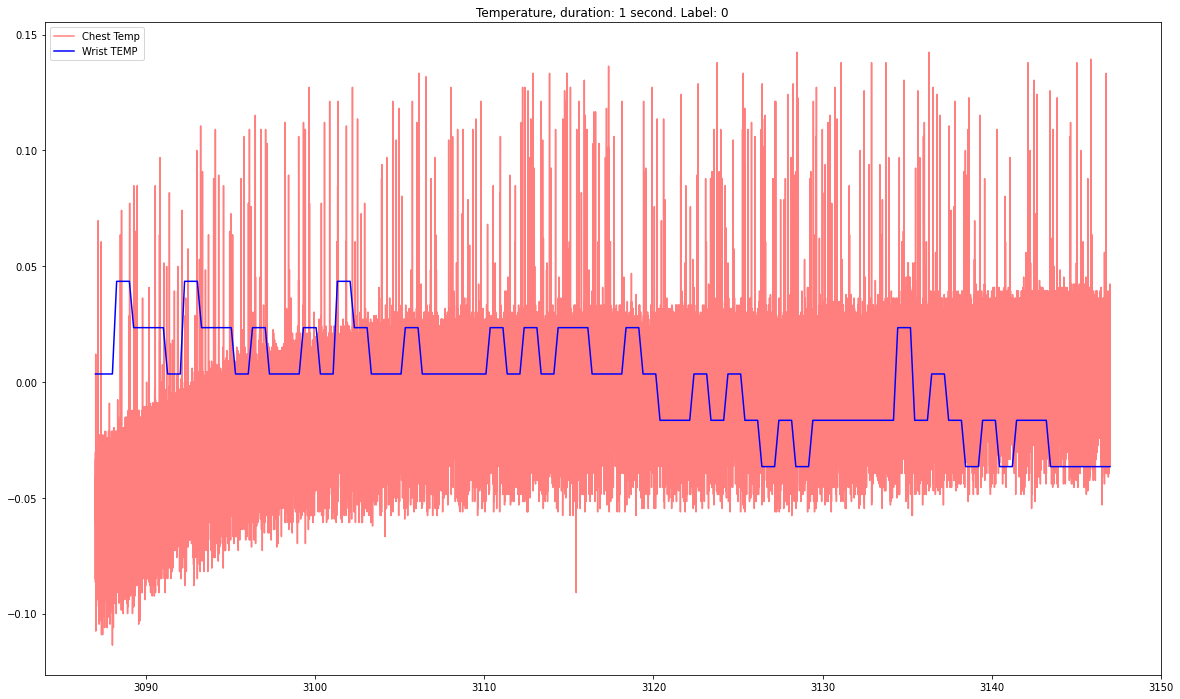

In [32]:
plt.plot(np.linspace(selected_second, selected_second + sample_duration, num=sample_duration*frequency_dict['chest']['Temp']), expl_data_dict_short['chest-Temp']-np.mean(expl_data_dict_short['chest-Temp']), 'r', alpha=0.5)
plt.plot(np.linspace(selected_second, selected_second + sample_duration, num=sample_duration*frequency_dict['wrist']['TEMP']), expl_data_dict_short['wrist-TEMP']-np.mean(expl_data_dict_short['wrist-TEMP']), 'b')
plt.title('Temperature, duration: 1 second. Label: ' + str(expl_data_dict_short['label']))
plt.legend(['Chest Temp', 'Wrist TEMP'])

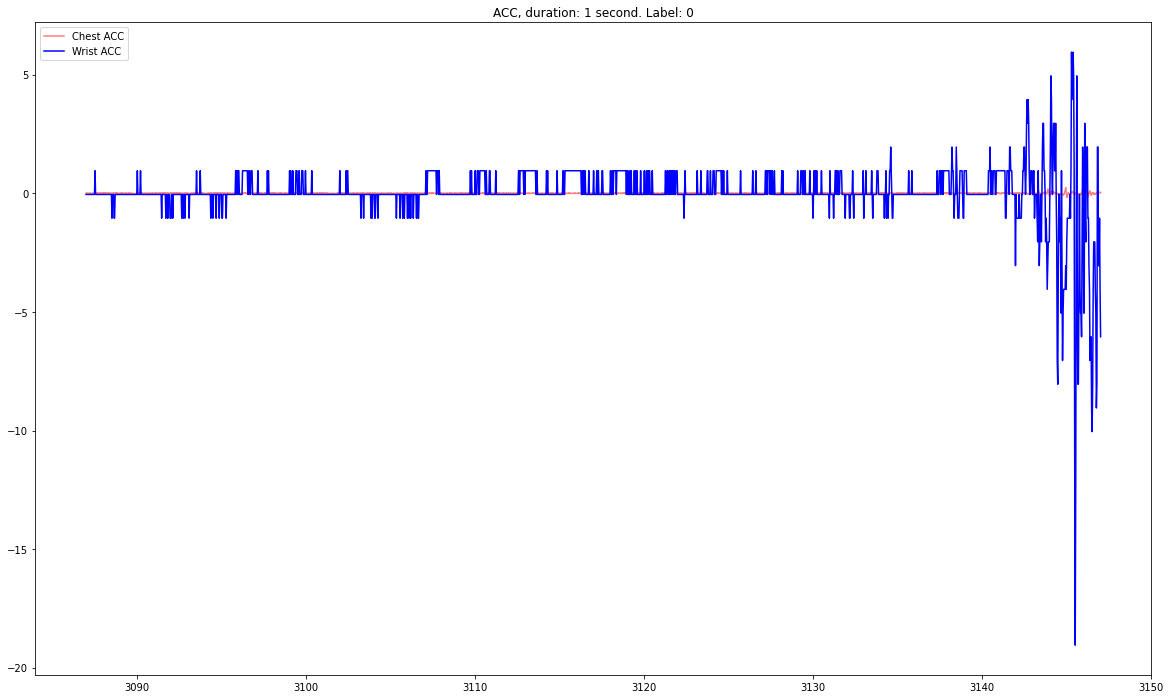

In [33]:
plt.plot(np.linspace(selected_second, selected_second + sample_duration, num=sample_duration*frequency_dict['chest']['ACC']), expl_data_dict_short['chest-ACC-0']-np.mean(expl_data_dict_short['chest-ACC-0']), 'r', alpha=0.5)
plt.plot(np.linspace(selected_second, selected_second + sample_duration, num=sample_duration*frequency_dict['wrist']['ACC']), expl_data_dict_short['wrist-ACC-0']-np.mean(expl_data_dict_short['wrist-ACC-0']), 'b')
plt.title('ACC, duration: 1 second. Label: ' + str(expl_data_dict_short['label']))
plt.legend(['Chest ACC', 'Wrist ACC'])

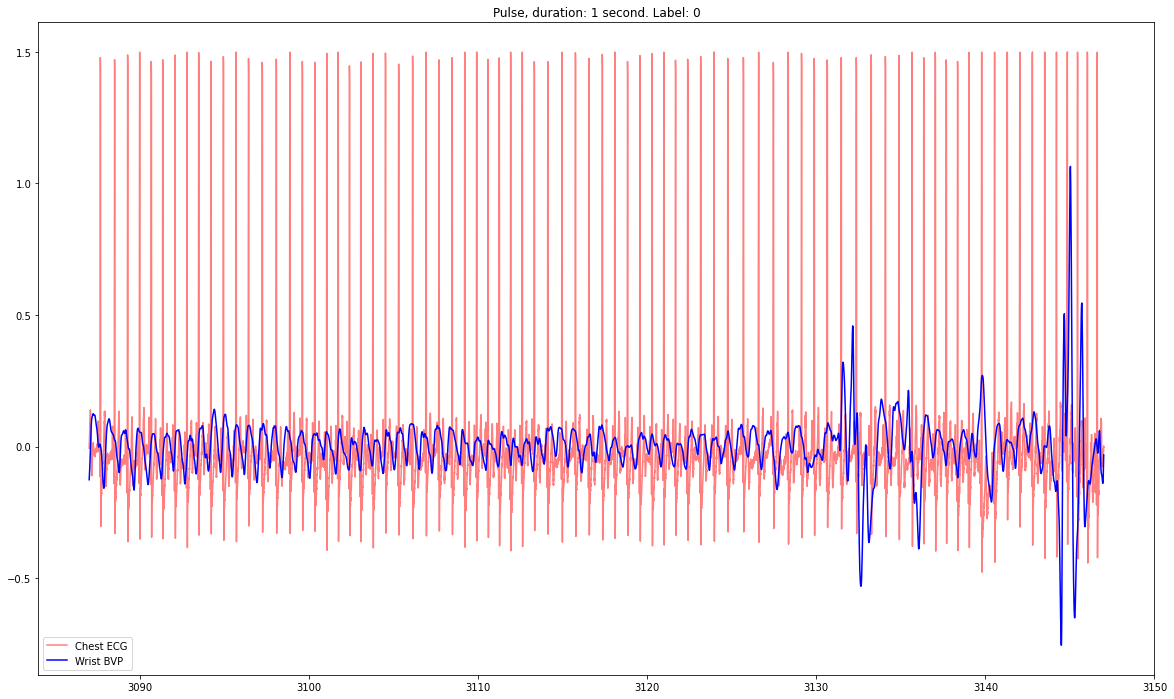

In [34]:
plt.plot(
    np.linspace(
        selected_second, selected_second + sample_duration, 
        num=sample_duration*frequency_dict['chest']['ECG']
    ), 
    expl_data_dict_short['chest-ECG']-np.mean(expl_data_dict_short['chest-ECG']), 
    'r', 
    alpha=0.5
)
plt.plot(
    np.linspace(
        selected_second, selected_second + sample_duration, 
        num=sample_duration*frequency_dict['wrist']['BVP']), 
    (expl_data_dict_short['wrist-BVP']-np.mean(expl_data_dict_short['wrist-BVP']))/100, 
    'b'
)
plt.title('Pulse, duration: 1 second. Label: ' + str(expl_data_dict_short['label']))
plt.legend(['Chest ECG', 'Wrist BVP'])

# Simple classifiers

Having explored the data, we would like to come up with some simple classifiers to use as benchmarks. These should take 60 second segments of data from the wrist-worn device and output a stress/non-stress classification.

* **Random guesser**. We just guess at random, stress/non-stress with 50/50 odds.
* **Sophisticated guesser**. We always guess non-stress, since this is the majority class.
* **Manually selected EDA Threshold**.
* **Learned EDA Threshold**.


# Feature engineering

In [37]:
from wesad_feature_extraction import *

In [38]:
# All subjects except for the test set
subject_numbers = [2, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17]

# Should be set to True when running for the first time
RUN_FEATURE_EXTRACTION = False

if RUN_FEATURE_EXTRACTION:
    for num in subject_numbers:
        with open('WESAD/S' + str(num) + '/S' + str(num) + '.pkl', 'rb') as f:
            print('----------------------')
            print('Processing subject ' + str(num))
            data_new = pickle.load(f,encoding='bytes' )
            data = data_collection(data_new)
            data['Target'] = make_target(data_new)[:data.shape[0]]
            data.to_csv('features' + '_' + str(num) + '_wrist.csv')
            data = None

In [39]:
# Getting the data from the created csv files

processed_data = []
for i in subject_numbers:
    processed_data.append(pd.read_csv('processed_data/features_' + str(i) + '_wrist.csv'))
    
processed_df = pd.concat(processed_data,axis=0,ignore_index=True)

In [40]:
processed_df.columns

Index(['Unnamed: 0', 'ACC_X_mean_wrist', 'ACC_Y_mean_wrist',
       'ACC_Z_mean_wrist', 'ACC_X_std_wrist', 'ACC_Y_std_wrist',
       'ACC_Z_std_wrist', 'ACC_X_max_wrist', 'ACC_Y_max_wrist',
       'ACC_Z_max_wrist', 'ACC_X_iabs_wrist', 'ACC_Y_iabs_wrist',
       'ACC_Z_iabs_wrist', 'ACC_3D_mean_wrist', 'ACC_3D_std_wrist',
       'ACC_3D_iabs_wrist', 'mean_EDA_wrist', 'std_EDA_wrist',
       'dynamic_range_EDA_wrist', 'slope_EDA_wrist', 'mean_Temp_wrist',
       'std_Temp_wrist', 'dynamic_range_Temp_wrist', 'slope_Temp_wrist',
       'mean_r', 'mean_l', 'std_r', 'std_l', 'peaks', 'HR_mean_BVP',
       'HR_std_BVP', 'HR_max_BVP', 'HR_min_BVP', 'NN50_BVP', 'pNN50_BVP',
       'rmssd_BVP', 'rr_mean_BVP', 'rr_std_BVP', 'ULF_BVP', 'HF_BVP', 'LF_BVP',
       'UHF_BVP', 'rate_L_H_BVP', 'Target'],
      dtype='object')

In [41]:
processed_df.shape

(296396, 44)

We have 42 features, one target and an index column. In total about 300,000 training examples.

In [42]:
# Remove the index column:
processed_df.drop(['Unnamed: 0'],axis = 1, inplace= True)

for i in [1,3,4,5,6,7]:
    processed_df['Target'].replace(i,0, inplace = True)

# Changing labels to stress and non-stress:
processed_df['Target'].replace(2,1, inplace = True)

<AxesSubplot:>

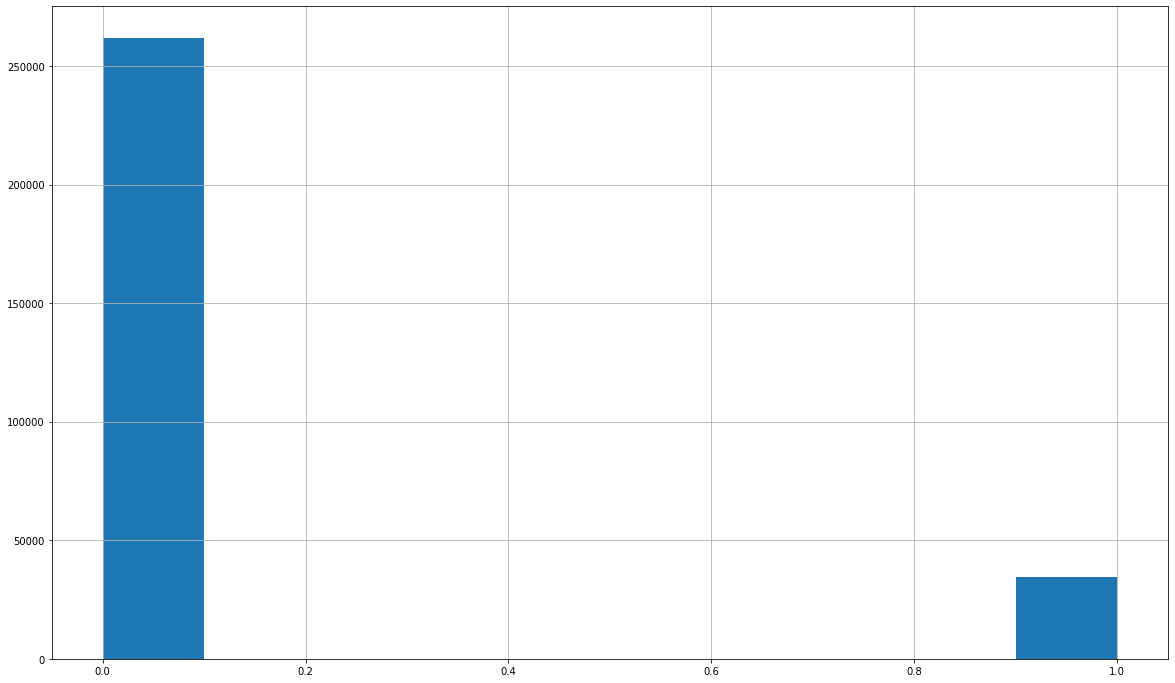

In [43]:
processed_df.Target.hist()

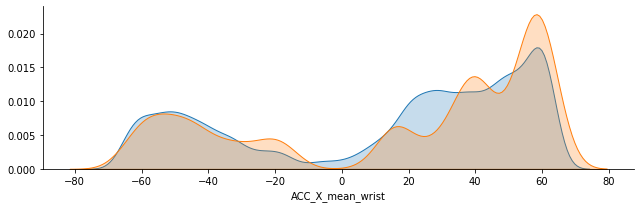

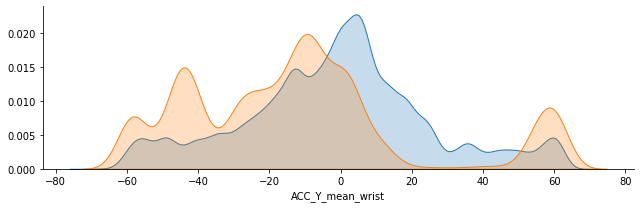

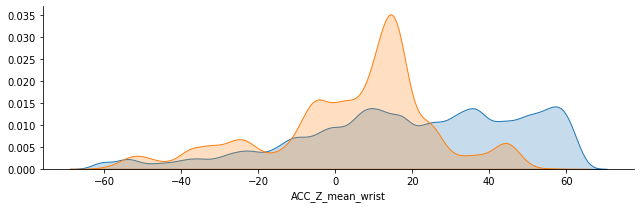

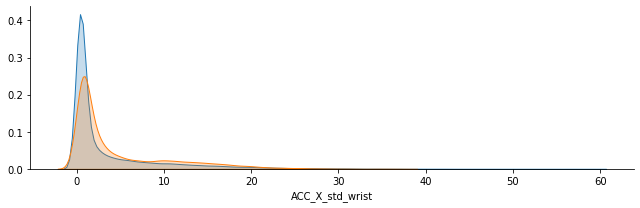

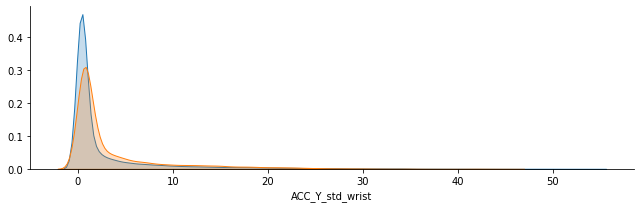

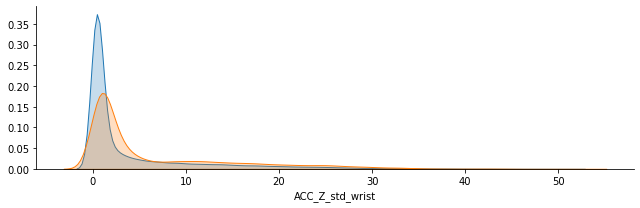

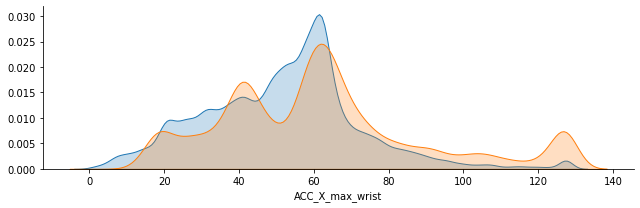

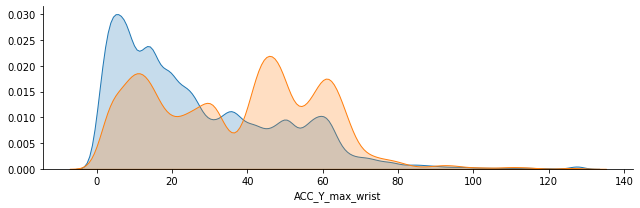

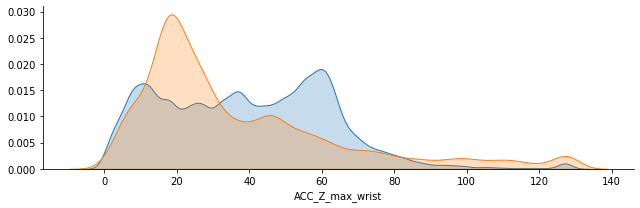

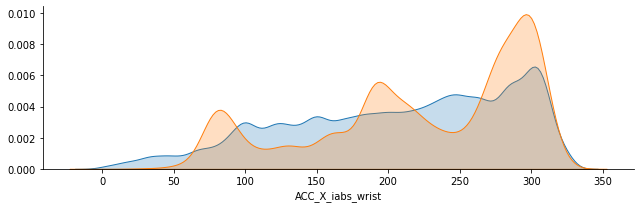

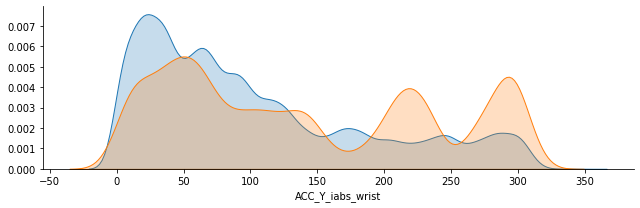

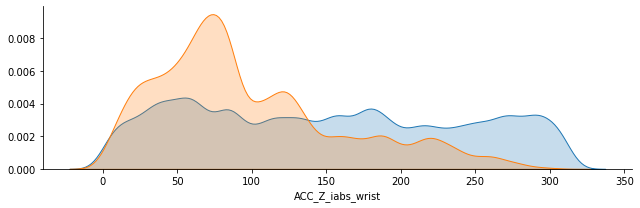

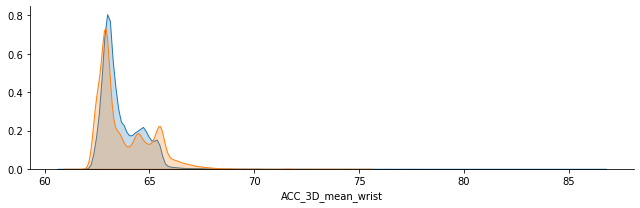

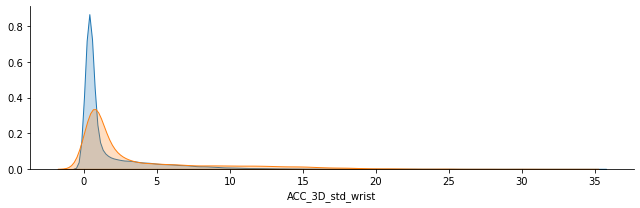

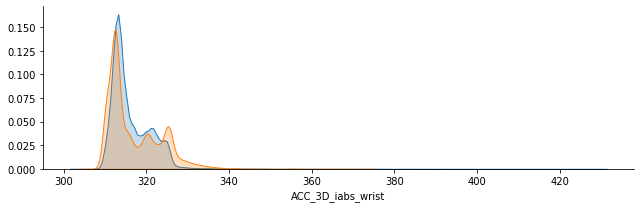

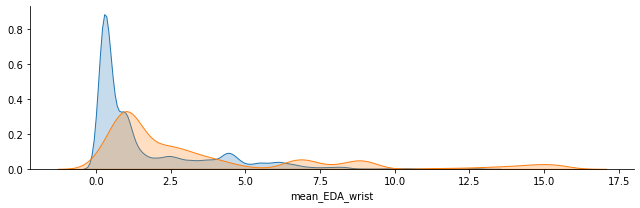

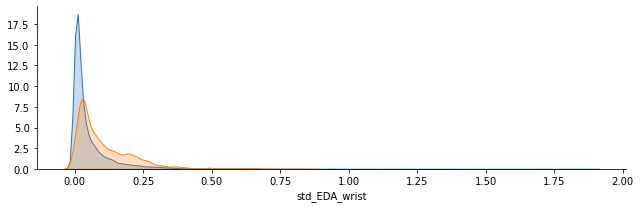

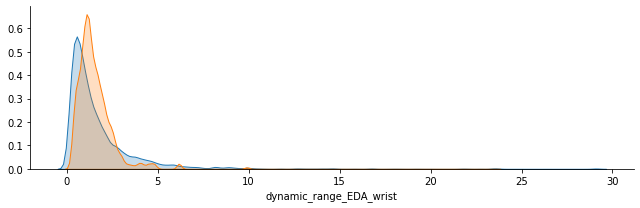

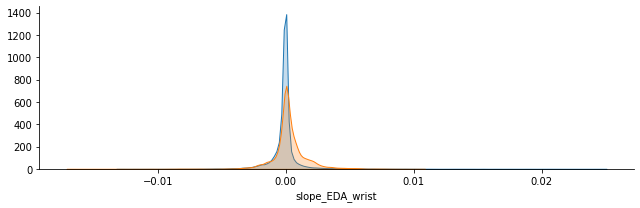

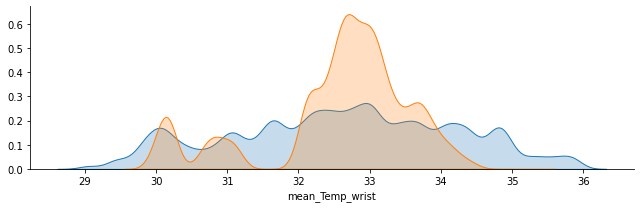

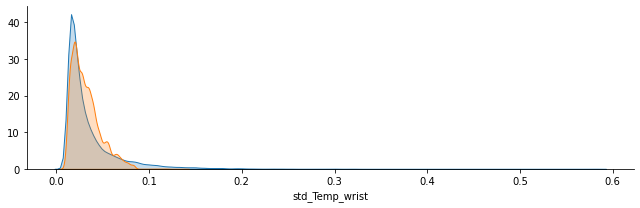

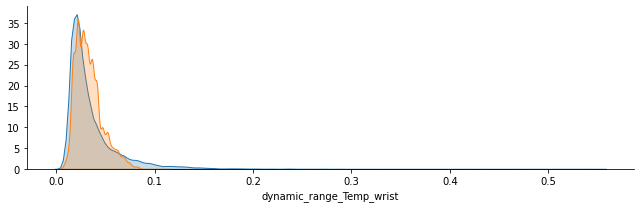

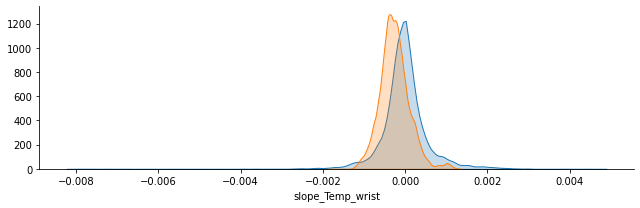

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


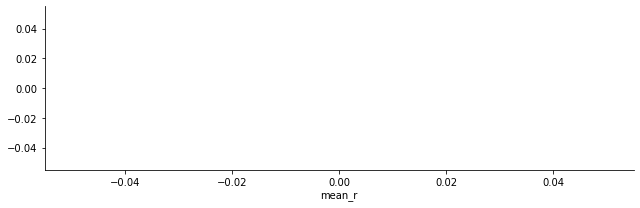

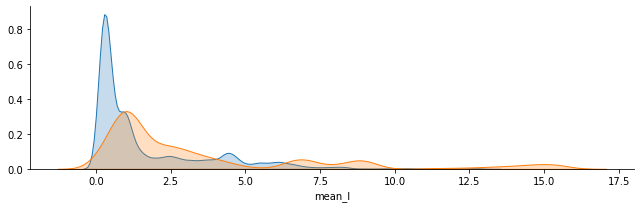

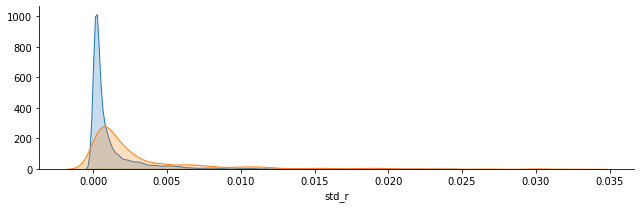

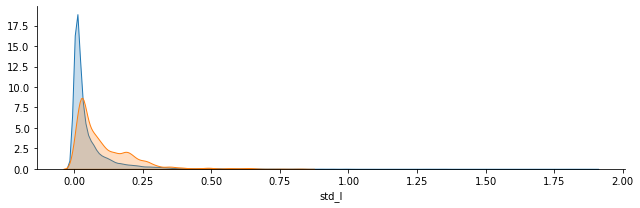

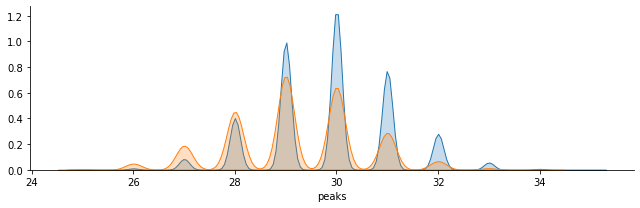

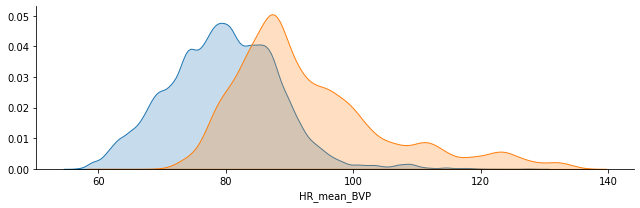

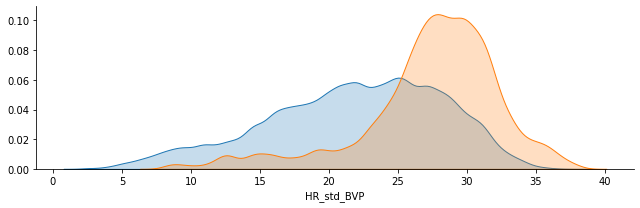

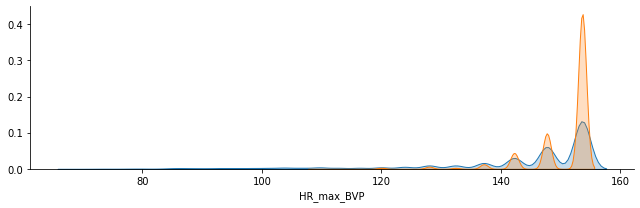

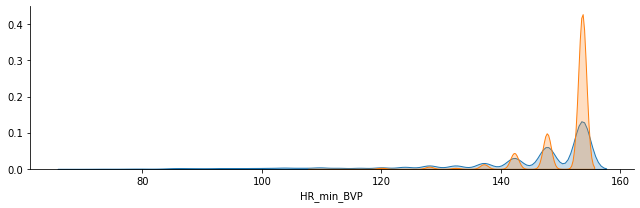

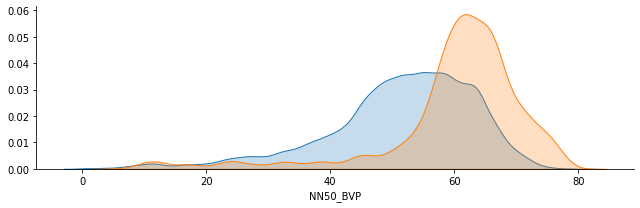

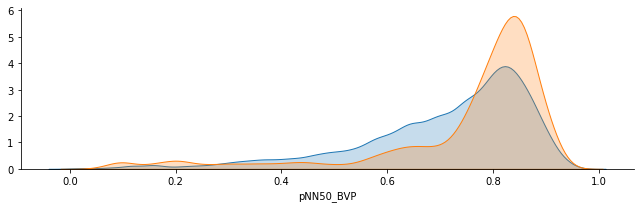

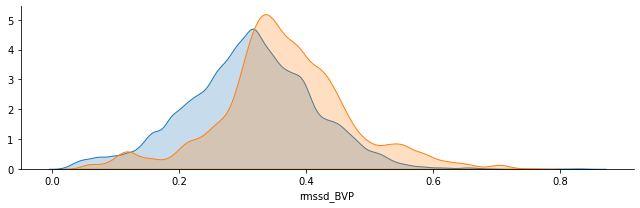

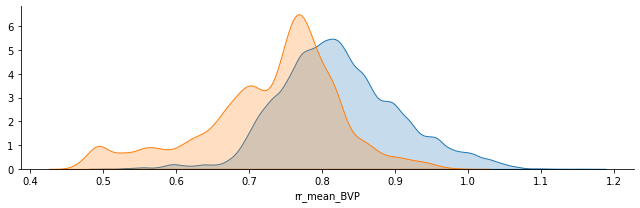

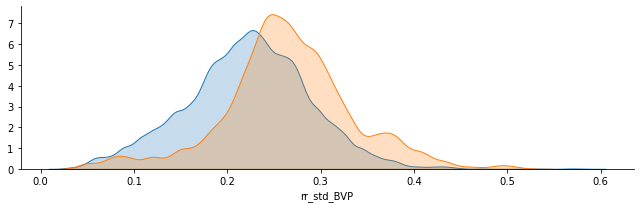

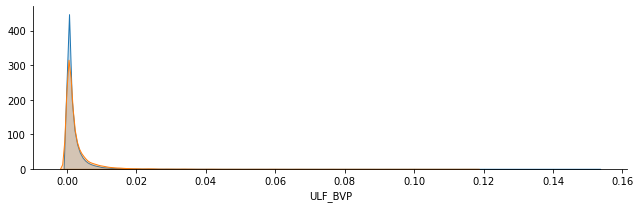

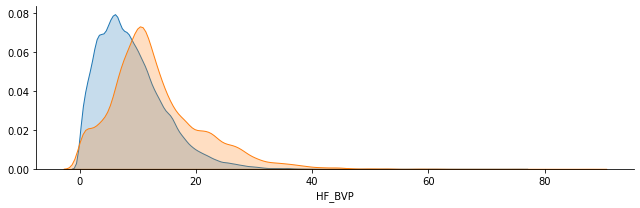

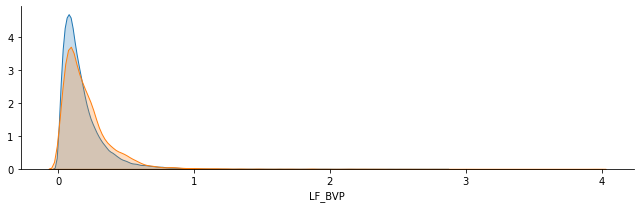

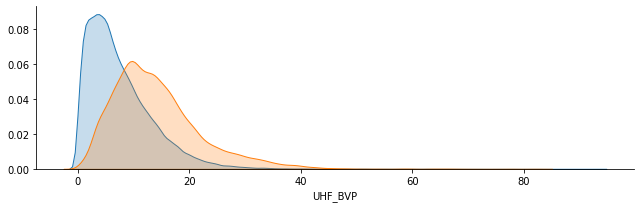

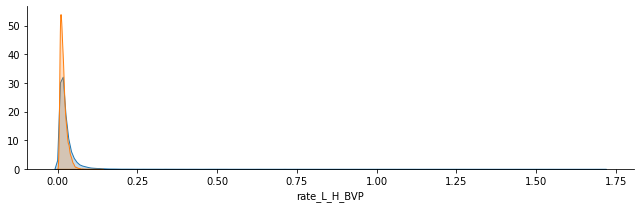

In [44]:
for col in processed_df.columns[0:-1]:
    fg = sns.FacetGrid(processed_df, hue="Target", aspect=3)
    fg.map(sns.kdeplot, col, shade=True)
    plt.show()

In [45]:
# Looking at these plots, we decide to remove the following features 
# before learning starts

processed_df.drop(
    [
        'ACC_X_std_wrist',
        'ACC_Y_std_wrist',
        'ACC_Z_std_wrist',
        'ACC_3D_mean_wrist',
        'ACC_3D_std_wrist',
        'ACC_3D_iabs_wrist',
        'mean_r',
        'HR_max_BVP',
        'HR_min_BVP',
        'ULF_BVP',
        'LF_BVP'
    ],
    axis=1,
    inplace=True
)


In [46]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296396 entries, 0 to 296395
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ACC_X_mean_wrist          296396 non-null  float64
 1   ACC_Y_mean_wrist          296396 non-null  float64
 2   ACC_Z_mean_wrist          296396 non-null  float64
 3   ACC_X_max_wrist           296396 non-null  float64
 4   ACC_Y_max_wrist           296396 non-null  float64
 5   ACC_Z_max_wrist           296396 non-null  float64
 6   ACC_X_iabs_wrist          296396 non-null  float64
 7   ACC_Y_iabs_wrist          296396 non-null  float64
 8   ACC_Z_iabs_wrist          296396 non-null  float64
 9   mean_EDA_wrist            296396 non-null  float64
 10  std_EDA_wrist             296396 non-null  float64
 11  dynamic_range_EDA_wrist   296396 non-null  float64
 12  slope_EDA_wrist           296396 non-null  float64
 13  mean_Temp_wrist           296396 non-null  f

In [47]:
from sklearn.utils import shuffle
processed_shuffled_df = shuffle(processed_df)
processed_shuffled_df.head()

,ACC_X_mean_wrist,ACC_Y_mean_wrist,ACC_Z_mean_wrist,ACC_X_max_wrist,ACC_Y_max_wrist,ACC_Z_max_wrist,ACC_X_iabs_wrist,ACC_Y_iabs_wrist,ACC_Z_iabs_wrist,mean_EDA_wrist,...,HR_std_BVP,NN50_BVP,pNN50_BVP,rmssd_BVP,rr_mean_BVP,rr_std_BVP,HF_BVP,UHF_BVP,rate_L_H_BVP,Target
212664,-43.34375,-45.40625,-14.72500,49.0,47.0,17.0,215.312500,225.640625,73.250000,0.311087,...,19.877425,55,0.743243,0.305744,0.801731,0.223980,5.869414,7.789724,0.025843,0
34322,-40.75000,-34.16875,34.76250,62.0,44.0,44.0,202.453125,169.843750,172.671875,0.167414,...,28.648833,57,0.904762,0.437275,0.934772,0.304912,21.220698,3.079311,0.018462,0
247590,36.51250,22.63125,8.24375,114.0,62.0,68.0,182.296875,229.453125,67.515625,0.793440,...,25.763779,58,0.725000,0.233781,0.739844,0.177209,8.392897,3.865285,0.016278,0
193609,38.90625,-11.13750,47.87500,41.0,13.0,49.0,193.343750,55.312500,237.859375,5.889728,...,16.211653,40,0.500000,0.232276,0.730078,0.157611,2.730216,8.129094,0.020423,0
273291,-55.14375,-12.25000,16.98750,96.0,54.0,52.0,274.171875,98.562500,96.312500,2.019412,...,24.291976,59,0.766234,0.229710,0.767248,0.195750,5.908764,3.412632,0.007549,0


In [48]:
X = processed_shuffled_df.drop(['Target'], axis=1)
y = processed_shuffled_df['Target']

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [50]:
# We will be making a new test set for the learning
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Modeling



In [51]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform, randint
import warnings

# Should be set to True when running for the first time
MODELING = False

warnings.simplefilter(action='default')

models = {
    'lr': LogisticRegression(solver='saga'),
    'rf': RandomForestClassifier(),
    'dt': DecisionTreeClassifier()
}

param_distributions = {
    'lr': {
        'penalty': ['l1', 'l2'],
        'C': uniform(0,5) # Inverse of regularization strength
    },
    'rf': {
        'max_depth': uniform(2,8),
        'n_estimators': randint(20,800) 
    },
    'dt': {
        'max_depth': uniform(2,8),      
    }
}

if MODELING:
    for name in models.keys():
        print('Searching ' + name)
        warnings.simplefilter(action='ignore')
        clf = RandomizedSearchCV(
            models[name], 
            param_distributions[name],
            scoring = 'f1',
            n_jobs=-1
        )
        search = clf.fit(X_train, y_train)
        warnings.simplefilter(action='default')
        print('Best ' + name + ' estimator:')
        print(search.best_estimator_)
        print('----------------------------------------')

Now we train the best estimators on full training set and validate on test set


In [52]:
best_rf = RandomForestClassifier(
    bootstrap=True, 
    ccp_alpha=0.0, 
    class_weight=None,   
    criterion='gini', 
    max_depth=8.841645268160933,
    max_features='auto',
    max_leaf_nodes=None,
    max_samples=None, 
    min_impurity_decrease=0.0,
    min_impurity_split=None, 
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=231, 
    n_jobs=None, 
    oob_score=False,
    random_state=None, verbose=0, warm_start=False)


if MODELING:
    best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8.841645268160933,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=231, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [53]:
best_dt = DecisionTreeClassifier(
    ccp_alpha=0.0, 
    class_weight=None, 
    criterion='gini',
    max_depth=9.600838219730791, 
    max_features=None,
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0,
    min_impurity_split=None, 
    min_samples_leaf=1,
    min_samples_split=2, 
    min_weight_fraction_leaf=0.0,
    presort='deprecated', 
    random_state=None,
    splitter='best'
)

if MODELING:
    best_dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9.600838219730791, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [54]:
best_lr = LogisticRegression(
    C=3.750947098406357, 
    class_weight=None, 
    dual=False,                             
    fit_intercept=True, 
    intercept_scaling=1, 
    l1_ratio=None,
    max_iter=100,
    multi_class='auto',
    n_jobs=None,
    penalty='l1',
    random_state=None,
    solver='saga',
    tol=0.0001,
    verbose=0,
    warm_start=False)

if MODELING:
    best_lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=3.750947098406357, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
from sklearn.metrics import (
    confusion_matrix, 
    f1_score, 
    accuracy_score, 
    precision_score, 
    recall_score
)

In [56]:
if MODELING:
    print('Logistic Regression predictions')
    lr_predictions = best_lr.predict(X_test)
    print(confusion_matrix(y_test, lr_predictions))
    print('Accuracy: ' + str(accuracy_score(y_test, lr_predictions)))
    print('F1 score: ' + str(f1_score(y_test, lr_predictions)))
    print('Precision: ' + str(precision_score(y_test, lr_predictions)))
    print('Recall: ' + str(recall_score(y_test, lr_predictions)))
    print('---------------------\n')

    print('Decision Tree predictions')
    dt_predictions = best_dt.predict(X_test)
    print(confusion_matrix(y_test, dt_predictions))
    print('Accuracy: ' + str(accuracy_score(y_test, dt_predictions)))
    print('F1 score: ' + str(f1_score(y_test, dt_predictions)))
    print('Precision: ' + str(precision_score(y_test, dt_predictions)))
    print('Recall: ' + str(recall_score(y_test, dt_predictions)))
    print('---------------------\n')

    print('Random Forest predictions')
    rf_predictions = best_rf.predict(X_test)
    print(confusion_matrix(y_test, rf_predictions))
    print('Accuracy: ' + str(accuracy_score(y_test, rf_predictions)))
    print('F1 score: ' + str(f1_score(y_test, rf_predictions)))
    print('Precision: ' + str(precision_score(y_test, rf_predictions)))
    print('Recall: ' + str(recall_score(y_test, rf_predictions)))


Logistic Regression predictions
[[51406  1072]
 [ 3755  3047]]
Accuracy: 0.9185728744939271
F1 score: 0.5580075084699204
Precision: 0.7397426559844622
Recall: 0.44795648338723904
---------------------

Decision Tree predictions
[[51437  1041]
 [  644  6158]]
Accuracy: 0.9715755735492577
F1 score: 0.8796514534676093
Precision: 0.8553965828587303
Recall: 0.9053219641281975
---------------------

Random Forest predictions
[[52424    54]
 [ 1580  5222]]
Accuracy: 0.9724358974358974
F1 score: 0.8647127007782744
Precision: 0.989764973464746
Recall: 0.76771537783005


## Modeling results

We got:

```
Logistic Regression predictions
[[51406  1072]
 [ 3755  3047]]
Accuracy: 0.9185728744939271
F1 score: 0.5580075084699204
Precision: 0.7397426559844622
Recall: 0.44795648338723904
---------------------

Decision Tree predictions
[[51437  1041]
 [  644  6158]]
Accuracy: 0.9715755735492577
F1 score: 0.8796514534676093
Precision: 0.8553965828587303
Recall: 0.9053219641281975
---------------------

Random Forest predictions
[[52424    54]
 [ 1580  5222]]
Accuracy: 0.9724358974358974
F1 score: 0.8647127007782744
Precision: 0.989764973464746
Recall: 0.76771537783005
```

# RNN with LSTM

Now we try modeling with RNNs. First, we need to split the training data into 60 second segments with 50% overlap. We will give each segement the majority label.

In [350]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14957 entries, 0 to 1182
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   eda     14957 non-null  object
 1   temp    14957 non-null  object
 2   bvp     14957 non-null  object
 3   label   14957 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 904.3+ KB


Accuracy of sophisticated guesser: 81%
Precision of sophisticated guesser: 0%
Recall of sophisticated guesser: 0%


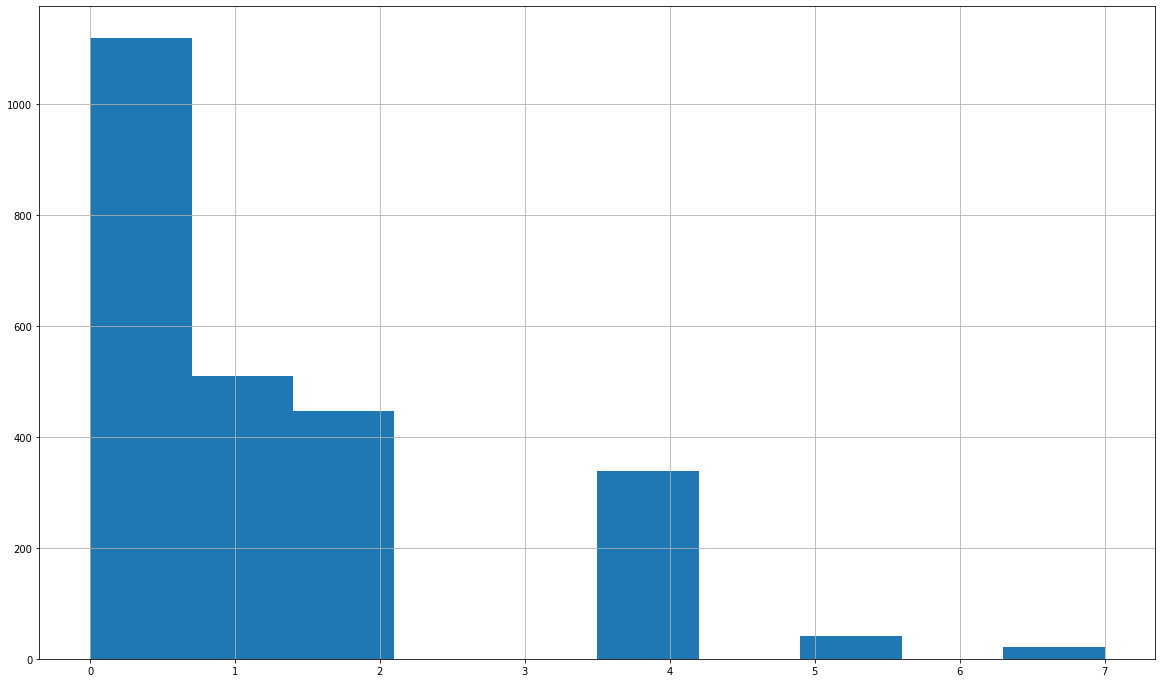

In [416]:
# The majority of segments have a non-stress label
df['label'].hist()

# Accuracy of sophisticated guesser:
n_stress = df[df['label']==2].count()[0]
n_total = df.count()[0]
print("Accuracy of sophisticated guesser: " + str(int(100 - 100*n_stress/n_total)) + '%')
print("Precision of sophisticated guesser: 0%")
print("Recall of sophisticated guesser: 0%")

In [60]:
#df60 = df.copy()

In [61]:
#df20 = df.copy()

In [417]:
# Changing labels to stress and non-stress:
for i in [1,3,4,5,6,7]:
    df['label'].replace(i,0, inplace = True)

df['label'].replace(2,1, inplace = True)

In [418]:
from sklearn.utils import shuffle
shuffled_df = shuffle(df)
shuffled_df.head()
print(shuffled_df.shape)

(2477, 4)


In [434]:
# Using EDA only

X_array = []
for row in df['eda']:
    X_array.append(row)
    
print(np.shape(X_array))
X_array = np.array(np.delete(X_array, -1, axis=0))

print(np.shape(X_array))
X_array = np.stack(X_array)
print(np.shape(X_array))

X_array = np.reshape(
    X_array, 
    (
        np.shape(X_array)[0],
        np.shape(X_array)[1],
        1
    )
)

y_array = []
for row in df['label']:
    y_array.append(row)

y_array = np.array(y_array[0:-1])
y_array = np.reshape(y_array, (np.shape(y_array)[0],1))
y_array = tf.keras.utils.to_categorical(y_array,2)

print(np.shape(X_array))
print(np.shape(y_array))
print(y_array)

(2477, 240)
(2476, 240)
(2476, 240)
(2476, 240, 1)
(2476, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [419]:
# Using EDA, Temp and BVP

X_array = [[],[],[]]
for row in df['eda']:
    X_array[0].append(row)
    
for row in df['temp']:
    X_array[1].append(row)
    
for row in df['bvp']:
    X_array[2].append(row)

X_array = np.array(np.delete(X_array, -1, axis=1))

print(np.shape(X_array))
X_array = np.stack(X_array)
print(np.shape(X_array))

X_array = np.reshape(
    X_array, 
    (
        np.shape(X_array)[1],
        np.shape(X_array)[2],
        np.shape(X_array)[0]
    )
)

y_array = []
for row in df['label']:
    y_array.append(row)

y_array = np.array(y_array[0:-1])
y_array = np.reshape(y_array, (np.shape(y_array)[0],1))
y_array = tf.keras.utils.to_categorical(y_array,2)

print(np.shape(X_array))
print(np.shape(y_array))
print(y_array)

(3, 2476, 240)
(3, 2476, 240)
(2476, 240, 3)
(2476, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [435]:
# We will be making a new test set for the learning
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size = 0.1)

In [260]:
import tensorflow as tf

In [444]:
rnnmodel = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(40, input_shape=(240,np.shape(X_array)[1])),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

rnnmodel.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=[
        'accuracy', 
    ]
)

In [443]:
rnnmodel.fit(
    X_train, 
    y_train, 
    batch_size=4, 
    epochs=5, 
    verbose=1
)

ValueError: Error when checking input: expected lstm_48_input to have shape (240, 2476) but got array with shape (240, 1)

In [440]:
rnnmodel.evaluate(X_test, y_test, batch_size=1, verbose=1)

248/248 [==============================] - 1s 5ms/sample - loss: 0.4313 - accuracy: 0.8387


[0.431270329702285, 0.83870965]

In [441]:
predictions = rnnmodel.predict(X_test)

rnn_predictions = []
for pred in predictions:
    rnn_predictions.append(pred.argmax())

rnn_labels = []
for label in y_test:
    rnn_labels.append(label.argmax())
    
print('RNN predictions')
print(confusion_matrix(rnn_labels, rnn_predictions))
print('Accuracy: ' + str(accuracy_score(rnn_labels, rnn_predictions)))
try:
    print('F1 score: ' + str(f1_score(rnn_labels, rnn_predictions)))
except:
    print('(Could not print F1 score)')
print('Precision: ' + str(precision_score(rnn_labels, rnn_predictions)))
print('Recall: ' + str(recall_score(rnn_labels, rnn_predictions)))
print('---------------------\n')

RNN predictions
[[207   2]
 [ 38   1]]
Accuracy: 0.8387096774193549
(Could not print F1 score)
Precision: 0.3333333333333333
Recall: 0.02564102564102564
---------------------



# Conclusion

* The best results were gotten using the Decision Tree learner on the feature engineered dataset.
* Not clear how this generalizes to a larger subject sample, since there are so few subjects
    * Did not want to take demographic data, such as gender and age of the subjects into account for this reason
* It would make sense to take more history into account than 60 seconds
* We are not quite predicting stress: Rather, we are predicting whether the subject is under stress conditioning. Our classifiers could for example have partially learned to distinguish between speaking and non-speaking circumstances, since the subjects mostly spoke during stress conditioning.
* We decided to include the undefined segments (labels 0, 5, 6 and 7) as non-stress segments.
* The RNN is not able to do any better than the sophisticated guesser. We are probably making some errors in the preprocessing.